# Census Folium Tutorial

## Kenneth Burchfiel

Released under the MIT license (except for color_schemes_from_branca.json, which I believe is copyrighted by Cynthia Brewer and licensed under the Apache License, Version 2.0)

This tutorial demonstrates how to use the functions in census_folium_viewer.py to generate interactive zip-, county-, and state-level choropleth maps based on census data and shapefiles from the US Census Bureau. Within the tutorial, I will generate maps representing three data types: (1) median household income; (2) the percentage of households that consist of a married couple with at least one child below the age of 18; and (3) population growth over various timeframes.

The tutorial also demonstrates how to incorporate a custom vertical legend into Folium maps. These have advantages over the default horizontal legend in certain circumstances.

**Note**: Some files in this project (such as the zip-code-level HTML maps) were too large to upload to GitHub. You can instead access those files via the following Google Drive folder: https://drive.google.com/drive/folders/11h1jnaVOA5A6ubbOJnC-kPEvdnJU00yv?usp=sharing


Citation info for color_schemes_from_branca.json:

Source: https://github.com/python-visualization/branca/blob/master/branca/_schemes.json

I believe these schemes were originally created by Cynthia Brewer, and are licensed under the Apache License, Version 2.0. See http://www.personal.psu.edu/cab38/ColorBrewer/ColorBrewer_updates.html

## Preliminary steps

First, you'll need to download zip code, county, and state shapefiles from the US Census bureau: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

I used 2020 zip code shapefiles for this project, which are available here: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=ZIP+Code+Tabulation+Areas

See this note regarding use of the shapefiles: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2021/TGRSHP2021_TechDoc_Ch1.pdf

Once you download the shapefiles to your computer, extract them using an unzipping utility. The shapefile document within this unzipped folder ends in .shp; for the 2020 zip code data, the file name is tl_2020_us_zcta520.shp. 

It appears that the other files within this folder may also be used by Geopandas in the creation of GeoDataFrames, so I recommend accessing the file within the unzipped folder rather than copying it into your project folder.

This project already contains zip-, county-, and state-level American Community Survey data (5-year estimates) for various demographic variables. I created these data files via my Census query tutorial available at https://github.com/kburchfiel/census_query_tutorial . 


In [1]:
import time
start_time = time.time()
import census_folium_viewer
import geopandas
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',1000) # Will make it easier to view
# all fields within a DataFrame
import folium
import os

In [2]:
acs_year = 2021 # The year of the most recent American Community Survey data used within this project.
# (This variable corresponds to the 'year' variable within the census_query_tutorial_vx.ipynb script within my census_query_tutorial project, with 'vx' referring to the most recent version of the script (e.g. v5).)
census_year = 2020 # The year of the most recent decennial Census data used within this project.
census_starting_year = 2000 # The year of the earliest decennial Census (which
# is incorporated into the title of some of the census datasets).
earliest_acs1_year = 2010 # The first year of ACS data for the 1-year
# county and state population charts. (Also used in some dataset titles)
second_newest_acs1_year = 2019 # The second-most-recent year of ACS1 data. 
# in the future, this can be replaced with acs_year - 1, but because 2020
# ACS1 data wasn't available (at least in some cases), we can't use that
# formula when acs_year is 2021.

In [3]:
html_save_path = os.getcwd()+'\\'+'census_folium_maps' # The absolute path of the current folder. This
# will serve as the save path for many of the charts created
# by this script.
html_save_path

'c:\\Users\\kburc\\D1V1\\Documents\\!Dell64docs\\Programming\\py\\kjb3_programs\\census_folium_tutorial\\census_folium_maps'

## Part 1: Zip Code-Level Maps

The following code block uses census_folium_viewer.py's prepare_zip_table() function to create a GeoDataFrame storing both zip code and census data. It took 133-148 seconds for the function to create a table on my computer, whereas importing a saved version of this file took 46-49 seconds. Therefore, to save time, I edited the code block so that it would only regenerate the GeoDataFrame if instructed to do so.

I recommend reading the documentation in census_folium_viewer.py for prepare_zip_table so that you'll better understand the inputs used by this function.

The zip code census data file only includes zip codes with at least 1,000 households, preventing outliers in the data related to low sample sizes.

In [4]:
create_new_zip_census_table = False

if create_new_zip_census_table == True:
    data_path = f'census_data/acs5_{acs_year}_zip_results_1k_plus_households.csv'
    print("Merging shapefile data with data from", data_path)
    zip_and_census_table = census_folium_viewer.prepare_zip_table(
        shapefile_path = r'C:/Users/kburc/Downloads/tl_2020_us_zcta520/tl_2020_us_zcta520.shp',
        shape_feature_name = 'ZCTA5CE20', tolerance = 0.005, data_path =
        data_path,
        data_feature_name = 'NAME', dropna_geometry = True)
    print("Exporting data:")
    zip_and_census_table.to_file('zip_and_census_table.geojson',
    driver = 'GeoJSON') 
    # The above line exports the GeoDataFrame created by prepare_zip_table 
    # so that it can be imported back into the program, which takes less time
    # than does recreating the GeoDataFrame.

After being stored within the project folder, this table gets re-read into Python. That way, the program will still function even if create_new_zip_census_table was set to false.

In [5]:
zip_and_census_table = geopandas.read_file('zip_and_census_table.geojson')

In [6]:
zip_and_census_table['zip_as_int'] = zip_and_census_table['ZCTA5CE20'].astype('int')

In [7]:
zip_and_census_table.query("(zip_as_int < 600) | (zip_as_int > 899)", inplace = True)
# The above line excludes Puerto Rico from our zip-code-level data analyses.
# It also happens to exclude any US Virgin Islands zip codes, but the census data doesn't
# appear to include the USVI anyway.
# (See  
# https://en.wikipedia.org/wiki/Postal_codes_in_Puerto_Rico#:~:text=Puerto%20Rico%20is%20allocated%20the,of%20San%20Juan%2C%20Puerto%20Rico )

First, I will create a map displaying median household income by zip code. If you haven't done so already, I highly recommend reading the documentation for generate_map so that you'll know what inputs are necessary for the function to run correctly.

Starting function
Creating color dict
Creating style function
Creating tooltip
Rendering map
Creating vertical legend (if requested)
Saving map
Generating screenshot
Returning map


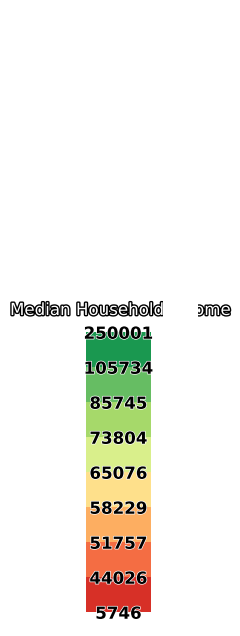

In [8]:
zip_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query("Median_household_income >= 0"),
    shape_feature_name = 'NAME',
    data_variable = "Median_household_income", feature_text = 'Zip Code',
    data_variable_text = 'Median Household Income',
    popup_variable_text = 'Income', 
    variable_decimals = None,
    map_name = f'zip_median_hh_income_acs5_{acs_year}',
    fill_color = 'RdYlGn',
    html_save_path = html_save_path,
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 1, 
    vertical_legend = True, debug = True)


In [9]:
# zip_median_hh_income_map

Next, I'll create a map showing the proportion of households in each zip code in the dataset that consist of a married couple with at least one child.

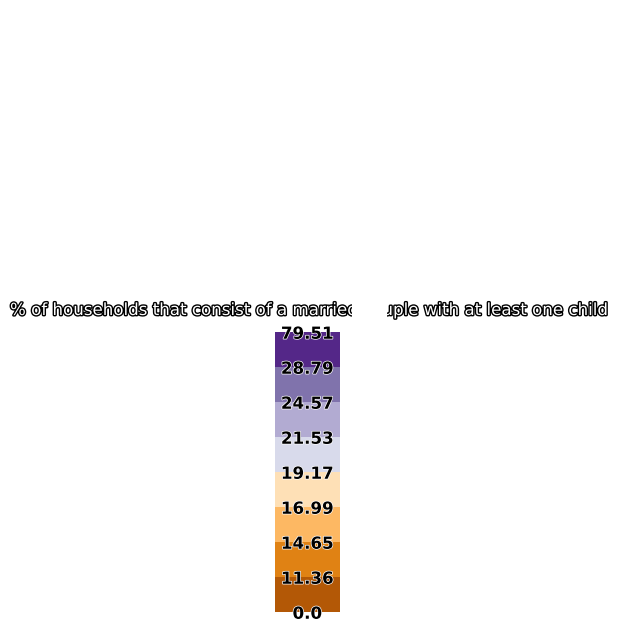

In [10]:
zip_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table,
    shape_feature_name = 'ZCTA5CE20',
    data_variable = "Married_couple_households_with_one_or_more_children_as_proportion_of_all_households",
    feature_text = 'Zip Code',
    data_variable_text= '% of households that consist of a married couple \
with at least one child',
    popup_variable_text = 'Percentage', 
    map_name = f'zip_married_couples_with_kids_acs5_{acs_year}', fill_color = 'PuOr', 
    bin_count = 8,
    html_save_path = html_save_path,
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

The following map shows the percentage of households with 1 or more kids that are headed by a married couple.

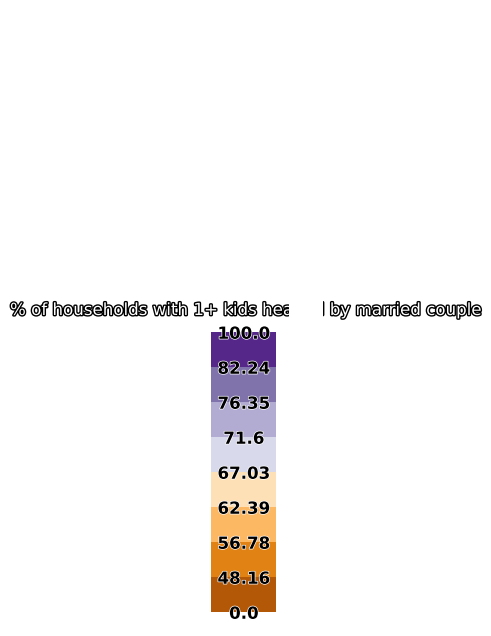

In [11]:
zip_marriage_prevalence_in_households_with_kids_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table,
    shape_feature_name = 'ZCTA5CE20',
    data_variable = "Married_couple_households_with_one_or_more_children_as_proportion_of_all_households_with_one_or_more_children",
    feature_text = 'Zip Code',
    data_variable_text= '% of households with 1+ kids headed by married couple',
    popup_variable_text = 'Percentage', 
    map_name = f'zip_marriage_prevalence_in_households_with_kids_acs5_{acs_year}', fill_color = 'PuOr', 
    bin_count = 8,
    html_save_path = html_save_path,
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

In [12]:
# zip_married_couples_with_children_map

## Part 2: County-Level Maps

The steps for generating county-level maps are similar. Note that the county census data file being imported only contains counties with at least 1,000 households.

In [13]:
data_path = f'census_data/acs5_{acs_year}_county_results_1k_plus_households.csv'
print("Merging shapefile data with data from", data_path)
county_and_census_table = census_folium_viewer.prepare_county_table(
    shapefile_path = r'C:/Users/kburc/Downloads/tl_2021_us_county/tl_2021_us_county.shp',
    shape_state_code_column = 'STATEFP', shape_county_code_column = 'COUNTYFP',
    tolerance = 0.005,
    data_path = data_path,
    data_state_code_column = 'state', data_county_code_column = 'county',
    dropna_geometry = True)
print("Exporting data:")
county_and_census_table.to_file('county_and_census_table.geojson',
    driver = 'GeoJSON') 

Merging shapefile data with data from census_data/acs5_2021_county_results_1k_plus_households.csv
Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


c:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [14]:
county_and_census_table

,STATEFP,COUNTYFP,COUNTYNS,GEOID,SHORT_NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME,Year,state,county,Total_population,Households,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:!!Family households:!!Married-couple family,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with no people under 18 years:!!Family households:!!Married-couple family,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Less than high school graduate:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!High school graduate (includes equivalency):,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Some college or associate's degree:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Bachelor's degree or higher:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Less than high school graduate,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!High school graduate (includes equivalency),"POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Mar

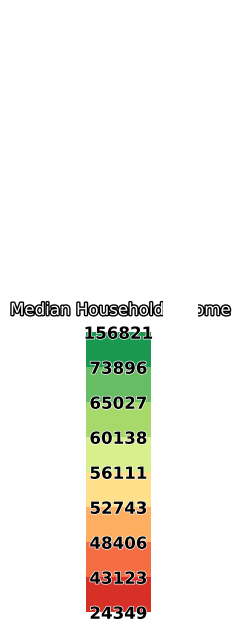

In [15]:
county_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72 & Median_household_income >= 0"), 
    shape_feature_name = 'NAME', # This column, which contains both county
    # and state names, came from the data table. It's more ideal to use this
    # one than the copy of 'NAME' from the Shapefile table (which contained)
    # only county names), since passing in a column with duplicate county names
    # could lead to incorrect map values. 
    data_variable = 'Median_household_income', feature_text = 'County',
    data_variable_text = 'Median Household Income',
    map_name = f'county_median_hh_income_acs5_{acs_year}', 
    variable_decimals = None,
    html_save_path = html_save_path,
    screenshot_save_path = 'census_folium_map_screenshots',
    popup_variable_text = 'Income', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 1, 
    vertical_legend = True)

# county_hh_income_map

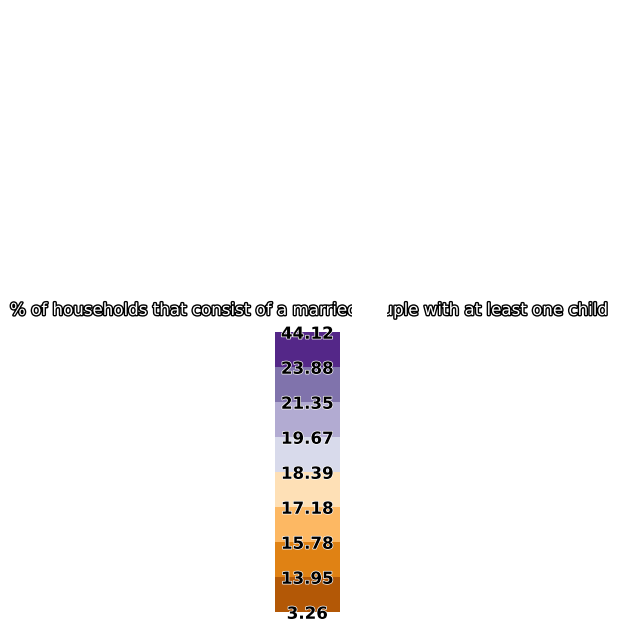

In [16]:
county_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households',
    feature_text = 'County', data_variable_text = '% of households \
that consist of a married couple with at least one child', 
    map_name = f'county_married_couples_with_kids_acs5_{acs_year}', 
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', bin_count = 8,
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

# county_married_couples_with_children_map

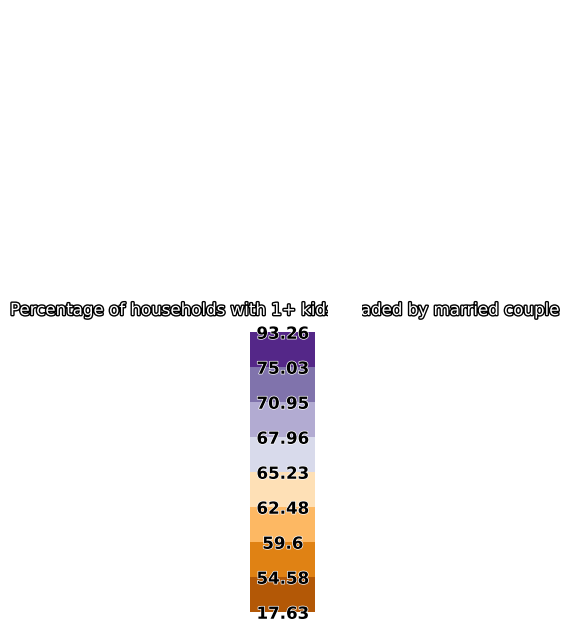

In [17]:
county_marriage_prevalence_in_households_with_kids_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households_with_one_or_more_children',
    feature_text = 'County', 
    data_variable_text = 'Percentage of households with 1+ kids headed by married couple', 
    map_name = f'county_marriage_prevalence_in_households_with_kids_acs5_{acs_year}', 
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', bin_count = 8,
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

# county_married_couples_with_children_map

# Part 3: State-Level Maps

Finally, I'll create state-level maps of median household income and married-couple family prevalence.

In [18]:
state_and_census_table = census_folium_viewer.prepare_state_table(
    shapefile_path = r'C:/Users/kburc/Downloads/tl_2020_us_state/tl_2020_us_state.shp', 
    shape_feature_name = 'NAME', tolerance = 0.005, data_path = 
    f'census_data/acs5_{acs_year}_state_results.csv', data_feature_name = 'NAME',
    dropna_geometry = True)
print("Exporting data:")
state_and_census_table.to_file('state_and_census_table.geojson',
driver = 'GeoJSON') 

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


c:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


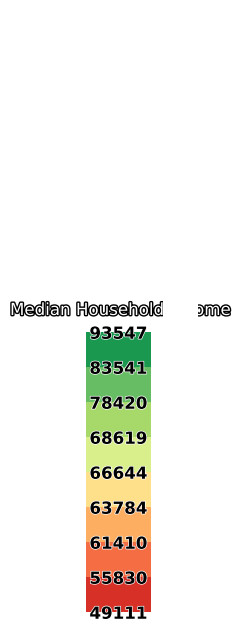

In [19]:
state_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72 & Median_household_income >= 0"), shape_feature_name = 'NAME',
    data_variable = 'Median_household_income', feature_text = 'State', 
    data_variable_text = 'Median Household Income', 
    map_name = f'state_median_hh_income_acs5_{acs_year}', 
    variable_decimals = None,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Income', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 1, vertical_legend = True, 
    generate_image = True)

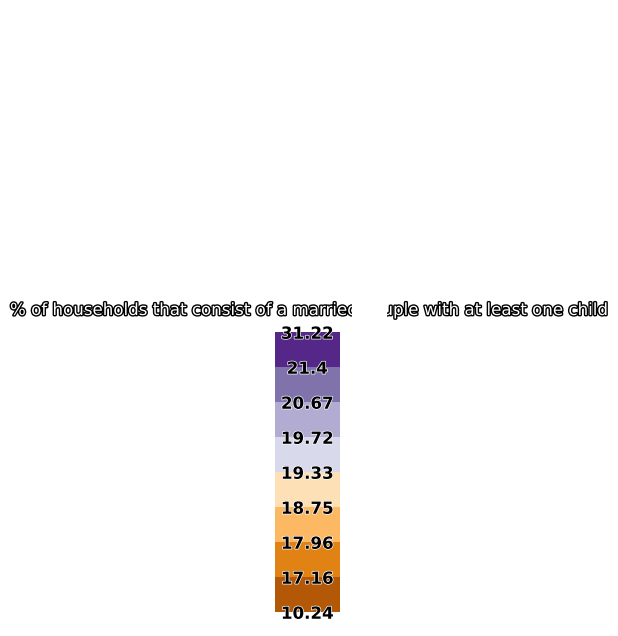

In [20]:
state_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("NAME != 'Puerto Rico'"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households', 
    feature_text = 'State', 
    data_variable_text = '% of households that consist of a married \
couple with at least one child', 
    map_name = f'state_married_couples_with_kids_acs5_{acs_year}', 
    html_save_path = html_save_path,
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', 
    rows_to_map = 0, bin_type = 'percentiles', bin_count = 8, 
    multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

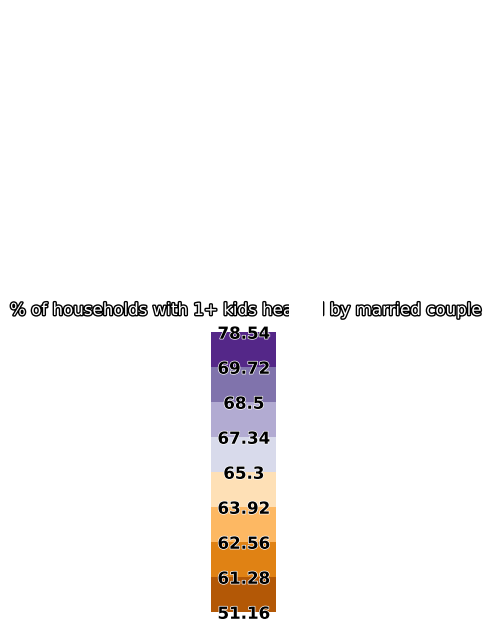

In [21]:
state_marriage_prevalence_in_households_with_kids_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("NAME != 'Puerto Rico'"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households_with_one_or_more_children', 
    feature_text = 'State', 
    data_variable_text = '% of households with 1+ kids headed by married couple', 
    map_name = f'state_marriage_prevalence_in_households_with_kids_acs5_{acs_year}', 
    html_save_path = html_save_path,
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', 
    rows_to_map = 0, bin_type = 'percentiles', bin_count = 8, 
    multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

## Visualizing population growth

The datasets merged into the state-, county-, and zip-level GeoDataFrame files did not contain very much population growth data. Therefore, the following code blocks will import additional population growth datasets into the program, then merge them into the pre-existing GeoDataFrames. (New GeoDataFrames could be created, but given how large the 'geometry' columns are for each GeoDataFrame, merging in new data columns is much more efficient.)

These new population growth datasets were created within my census_query_tutorial project, also available on GitHub. They contain data from the decennial US Census; the American Community Survey (5-year estimates); and the American Community Survey (1-year estimates). It's interesting to see the differences in results between US Census and American Community Survey data over equivalent timeframes.

### Merging state-level population growth datasets into state_and_census_data

In [22]:
df_census_state_pop_growth = pd.read_csv(
    f'census_data/census_state_population_{census_starting_year}_to_{census_year}.csv')
for column in df_census_state_pop_growth.columns[2:]:
    df_census_state_pop_growth.rename(
        columns = {column:"census_"+column}, inplace = True)
    # Renaming population columns based on the data source will make it easier
    # to distinguish between different data sources.
df_census_state_pop_growth.drop('state', axis = 1, inplace = True) # the 
# 'state' column isn't necessary here because it already exists within
# state_and_census_data.



In [23]:
df_census_state_pop_growth.head()

,NAME,census_population_2000,census_population_2010,census_population_2020,census_2000_to_2010_chg,census_2010_to_2020_chg,census_2000_to_2020_chg
0,Alabama,4447100,4779736,5024279,0.074798,0.051162,0.129788
1,Alaska,626932,710231,733391,0.132868,0.032609,0.169809
2,Arizona,5130632,6392017,7151502,0.245854,0.118818,0.393883
3,Arkansas,2673400,2915918,3011524,0.090715,0.032788,0.126477
4,California,33871648,37253956,39538223,0.099857,0.061316,0.167296


In [24]:
df_acs5_state_pop_growth = pd.read_csv(f'census_data/acs5_state_pop_{acs_year-10}_{acs_year-5}_{acs_year}.csv') # Assumes that this dataset contains data for acs_year along
# with the years that occurred 5 and 10 years before it.
for column in df_acs5_state_pop_growth.columns[2:]:
    df_acs5_state_pop_growth.rename(columns = {column:"acs5_"+column}, inplace = True)
df_acs5_state_pop_growth.drop('state', axis = 1, inplace = True)
df_acs5_state_pop_growth.head()

,NAME,acs5_population_2011,acs5_population_2016,acs5_population_2021,acs5_2011_to_2016_chg,acs5_2016_to_2021_chg,acs5_2011_to_2021_chg
0,Mississippi,2956700,2989192,2967023,0.010989,-0.007416,0.003491
1,Missouri,5955802,6059651,6141534,0.017437,0.013513,0.031185
2,Montana,982854,1023391,1077978,0.041244,0.053339,0.096783
3,Nebraska,1813061,1881259,1951480,0.037615,0.037327,0.076345
4,Nevada,2673396,2839172,3059238,0.062010,0.077511,0.144327


In [25]:
df_acs1_state_pop_growth = pd.read_csv(f'census_data/acs1_state_pop_{earliest_acs1_year}_to_{acs_year}.csv')
# This data represents 1-year estimates, making it possible to examine
# estimated population changes within a 1-year timeframe.
for column in df_acs1_state_pop_growth.columns[2:]:
    df_acs1_state_pop_growth.rename(columns = {column:"acs1_"+column}, 
    inplace = True)
df_acs1_state_pop_growth.drop('state', axis = 1, inplace = True)
df_acs1_state_pop_growth.head()

,NAME,acs1_population_2010,acs1_population_2011,acs1_population_2012,acs1_population_2013,acs1_population_2014,acs1_population_2015,acs1_population_2016,acs1_population_2017,acs1_population_2018,acs1_population_2019,acs1_population_2021,acs1_2010_to_2011_chg,acs1_2011_to_2012_chg,acs1_2012_to_2013_chg,acs1_2013_to_2014_chg,acs1_2014_to_2015_chg,acs1_2015_to_2016_chg,acs1_2016_to_2017_chg,acs1_2017_to_2018_chg,acs1_2018_to_2019_chg,acs1_2019_to_2021_chg,acs1_2010_to_2021_chg
0,Alabama,4785298,4802740,4822023,4833722,4849377,4858979,4863300,4874747,4887871,4903185,5039877,0.003645,0.004015,0.002426,0.003239,0.001980,0.000889,0.002354,0.002692,0.003133,0.027878,0.053200
1,Alaska,713985,722718,731449,735132,736732,738432,741894,739795,737438,731545,732673,0.012231,0.012081,0.005035,0.002176,0.002307,0.004688,-0.002829,-0.003186,-0.007991,0.001542,0.026174
2,Arizona,6413737,6482505,6553255,6626624,6731484,6828065,6931071,7016270,7171646,7278717,7276316,0.010722,0.010914,0.011196,0.015824,0.014348,0.015086,0.012292,0.022145,0.014930,-0.000330,0.134489
3,Arkansas,2921606,2937979,2949131,2959373,2966369,2978204,2988248,3004279,3013825,3017804,3025891,0.005604,0.003796,0.003473,0.002364,0.003990,0.003373,0.005365,0.003177,0.001320,0.002680,0.035694
4,California,37349363,37691912,38041430,38332521,38802500,39144818,39250017,39536653,39557045,39512223,39237836,0.009171,0.009273,0.007652,0.012261,0.008822,0.002687,0.007303,0.000516,-0.001133,-0.006944,0.050562


The following code block merges these new population growth datasets into state_and_census_table.

In [26]:
state_and_census_table = state_and_census_table.merge(
    df_census_state_pop_growth, on = 'NAME', how = 'outer')
state_and_census_table = state_and_census_table.merge(df_acs5_state_pop_growth, 
on = 'NAME', how = 'outer')
state_and_census_table = state_and_census_table.merge(df_acs1_state_pop_growth,
on = 'NAME', how = 'outer')
state_and_census_table.to_file('state_and_census_table.geojson',
driver = 'GeoJSON') 
state_and_census_table

c:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Year,state,Total_population,Households,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:!!Family households:!!Married-couple family,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with no people under 18 years:!!Family households:!!Married-couple family,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Less than high school graduate:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!High school graduate (includes equivalency):,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Some college or associate's degree:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Bachelor's degree or higher:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Less than high school graduate,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!High school graduate (includes equivalency),"POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Some college, associate

Next, similar steps will be taken to update county_and_census_table and zip_and_census_table with population growth values.

In [27]:
df_census_county_pop_growth = pd.read_csv(
    f'census_data/census_county_population_{census_starting_year}_to_{census_year}.csv')
for column in df_census_county_pop_growth.columns[3:]:
    df_census_county_pop_growth.rename(
        columns = {column:"census_"+column}, inplace = True)
df_census_county_pop_growth


,NAME,state,county,census_population_2000,census_population_2020,census_population_2010,census_2000_to_2010_chg,census_2010_to_2020_chg,census_2000_to_2020_chg
0,"Autauga County, Alabama",1,1,43671.0,58805,54571.0,0.249594,0.077587,0.346546
1,"Baldwin County, Alabama",1,3,140415.0,231767,182265.0,0.298045,0.271594,0.650586
2,"Barbour County, Alabama",1,5,29038.0,25223,27457.0,-0.054446,-0.081364,-0.131380
3,"Bibb County, Alabama",1,7,20826.0,22293,22915.0,0.100307,-0.027144,0.070441
4,"Blount County, Alabama",1,9,51024.0,59134,57322.0,0.123432,0.031611,0.158945
...,...,...,...,...,...,...,...,...,...
3203,"Vega Baja Municipio, Puerto Rico",72,145,61929.0,54414,59662.0,-0.036606,-0.087962,-0.121349
3204,"Vieques Municipio, Puerto Rico",72,147,9106.0,8249,9301.0,0.021414,-0.113106,-0.094114
3205,"Villalba Municipio, Puerto Rico",72,149,27913.0,22093,26073.0,-0.065919,-0.152648,-0.208505
3206,"Yabucoa Municipio, Puerto Rico",72,151,39246.0,30426,37941.0,-0.033252,-0.198071,-0.224736


In [28]:
df_acs5_county_pop_growth = pd.read_csv(f'census_data/acs5_county_pop_{acs_year-10}_{acs_year-5}_{acs_year}.csv')
for column in df_acs5_county_pop_growth.columns[3:]:
    df_acs5_county_pop_growth.rename(columns 
    = {column:"acs5_"+column}, inplace = True)
df_acs5_county_pop_growth.drop(['state', 'county'], axis = 1, inplace = True)
df_acs5_county_pop_growth


,NAME,acs5_population_2011,acs5_population_2016,acs5_population_2021,acs5_2011_to_2016_chg,acs5_2016_to_2021_chg,acs5_2011_to_2021_chg
0,"Sweetwater County, Wyoming",43152.0,44812.0,42459.0,0.038469,-0.052508,-0.016060
1,"Platte County, Wyoming",8681.0,8740.0,8607.0,0.006796,-0.015217,-0.008524
2,"Sheridan County, Wyoming",28743.0,29924.0,30812.0,0.041088,0.029675,0.071983
3,"Big Horn County, Wyoming",11553.0,11931.0,11671.0,0.032719,-0.021792,0.010214
4,"Crook County, Wyoming",6926.0,7284.0,7185.0,0.051689,-0.013591,0.037395
...,...,...,...,...,...,...,...
3210,"Oneida County, Idaho",4225.0,4269.0,4514.0,0.010414,0.057390,0.068402
3211,"Gem County, Idaho",16783.0,16853.0,18692.0,0.004171,0.109120,0.113746
3212,"Valley County, Idaho",9877.0,9897.0,11476.0,0.002025,0.159543,0.161891
3213,"Adams County, Idaho",3980.0,3865.0,4321.0,-0.028894,0.117982,0.085678


The 'NAME' column in county_and_census_table is incomplete, as it only contains values for counties present in the original dataset that was merged into the county shapefile DataFrame. Therefore, the first merge operation will use state and county values instead, and the current 'NAME' column will be renamed so as to avoid a conflict with the 'NAME' column in df_acs5_zip_pop_growth.

The second merge operation can use 'NAME,' since this column now refers to a more complete set of county names.

In [29]:
county_and_census_table.rename(columns={'NAME':'old_name'},inplace=True)
county_and_census_table.drop(['state', 'county'], axis = 1, inplace = True)
county_and_census_table = county_and_census_table.merge(
    df_census_county_pop_growth, 
    left_on = ['STATEFP', 'COUNTYFP'], right_on = ['state', 'county'],
    how = 'outer')
county_and_census_table = county_and_census_table.merge(df_acs5_county_pop_growth, 
on = 'NAME',  how = 'outer')
county_and_census_table.dropna(subset = 'geometry', inplace = True)
county_and_census_table.to_file('county_and_census_table.geojson',
driver = 'GeoJSON') 
county_and_census_table

c:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,STATEFP,COUNTYFP,COUNTYNS,GEOID,SHORT_NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,old_name,Year,Total_population,Households,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:!!Family households:!!Married-couple family,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with no people under 18 years:!!Family households:!!Married-couple family,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Less than high school graduate:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!High school graduate (includes equivalency):,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Some college or associate's degree:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Bachelor's degree or higher:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Less than high school graduate,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!High school graduate (includes equivalency),"POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-coup

In [30]:
county_and_census_table.to_csv('county_and_census_table.csv')

In [31]:
df_acs5_zip_pop_growth = pd.read_csv(f'census_data/acs5_zip_pop_{acs_year-5}_{acs_year}.csv')
# The zip code values in the 'NAME' column were converted into integers,
# which is not ideal, as this changes the value of zip codes with leading 
# zeroes. (In addition, the merge operation won't work successfully unless
# both 'NAME' columns share the same data type and values.
# Therefore, these values will be converted back into strings 
# and, where necessary, revised to include leading zeroes.
df_acs5_zip_pop_growth['NAME'] = df_acs5_zip_pop_growth['NAME'].astype('str')
df_acs5_zip_pop_growth['NAME'] = df_acs5_zip_pop_growth['NAME'].str.zfill(5)
for column in df_acs5_zip_pop_growth.columns[2:]:
    df_acs5_zip_pop_growth.rename(
        columns = {column:'acs5_'+column}, inplace = True)
if 'state' in df_acs5_zip_pop_growth.columns:
    df_acs5_zip_pop_growth.drop('state', axis = 1, inplace = True)
df_acs5_zip_pop_growth

,NAME,acs5_population_2016,acs5_population_2021,acs5_2016_to_2021_chg
0,99119,1209.0,1491.0,0.233251
1,99128,209.0,291.0,0.392344
2,99141,5140.0,5902.0,0.148249
3,99149,180.0,197.0,0.094444
4,99153,390.0,424.0,0.087179
...,...,...,...,...
32758,60619,62822.0,63481.0,0.010490
32759,60621,31383.0,26538.0,-0.154383
32760,60636,35779.0,30412.0,-0.150004
32761,60639,90211.0,89037.0,-0.013014


In [32]:
zip_and_census_table.rename(columns = {'NAME':'old_NAME'}, inplace = True) 
# The 'NAME' column in zip_and_census_table
# is incomplete, as it only contains values for zip codes
# present in the original dataset that was merged into
# the shapefile DataFrame. Therefore, 'ZCTA5CE20' (a more
# complete set of zip code values) will be used for the
# following merge operation, and the current 'NAME' column
# will be renamed so as to avoid a conflict with the 'NAME' column 
# in df_acs5_zip_pop_growth.
zip_and_census_table = zip_and_census_table.merge(df_acs5_zip_pop_growth, 
left_on = 'ZCTA5CE20', right_on = 'NAME', how = 'outer')
# 'ZCTA5CE20' is used instead of 'old_NAME' for the left_on value
# because only zip codes present in the original dataset 
# that was merged into the shapefile dataset have 'NAME' 
# values.

zip_and_census_table

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,old_NAME,Year,Total_population,Households,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:!!Family households:!!Married-couple family,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with no people under 18 years:!!Family households:!!Married-couple family,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Less than high school graduate:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!High school graduate (includes equivalency):,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Some college or associate's degree:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Bachelor's degree or higher:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Less than high school graduate,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!High school graduate (includes equivalency),"POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Some college, associate's degree",POVERTY ST

In [33]:
zip_and_census_table.to_csv('zip_and_census_table.csv')

# Creating population growth maps:

Finally, a series of state-, county-, and zip-level population growth
maps will be created. Note that multiply_data_by is set to 100 in order 
to convert the growth values into percentages.

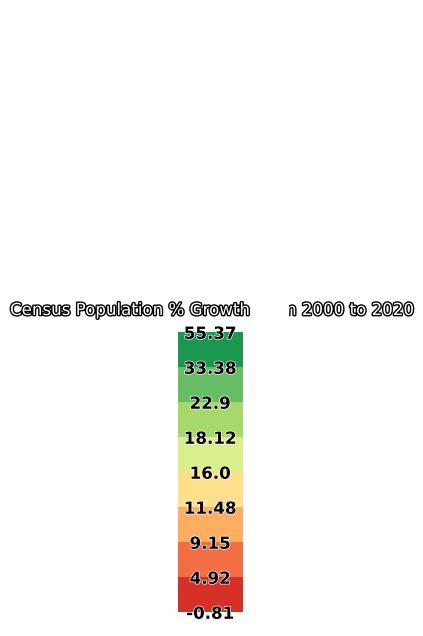

In [34]:
census_state_population_growth = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = f'census_{census_starting_year}_to_{census_year}_chg', feature_text = 'State', 
    data_variable_text = f'Census Population % Growth From {census_starting_year} to {census_year}', 
    map_name = f'census_{census_starting_year}_{census_year}_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

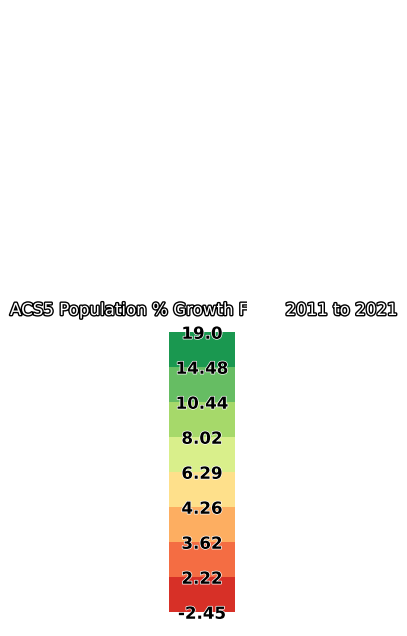

In [35]:
acs5_10_year_state_population_growth = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = f'acs5_{acs_year-10}_to_{acs_year}_chg', feature_text = 'State', 
    data_variable_text = f'ACS5 Population % Growth From {acs_year-10} to {acs_year}', 
    map_name = f'acs5_{acs_year-10}_{acs_year}_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

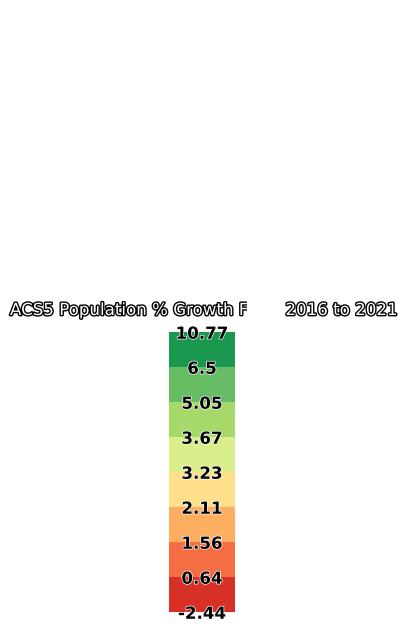

In [36]:
acs5_5_year_state_population_growth = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = f'acs5_{acs_year-5}_to_{acs_year}_chg', feature_text = 'State', 
    data_variable_text = f'ACS5 Population % Growth From {acs_year-5} to {acs_year}', 
    map_name = f'acs5_{acs_year-5}_{acs_year}_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

In [37]:
state_and_census_table.head(3)

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Year,state,Total_population,Households,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with one or more people under 18 years:!!Family households:!!Married-couple family,HOUSEHOLDS BY PRESENCE OF PEOPLE UNDER 18 YEARS BY HOUSEHOLD TYPE Estimate!!Total:!!Households with no people under 18 years:!!Family households:!!Married-couple family,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Less than high school graduate:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!High school graduate (includes equivalency):,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Some college or associate's degree:,EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER Estimate!!Total:!!Bachelor's degree or higher:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months below poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:,POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In married-couple family:,"POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Male householder, no spouse present:","POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!In other family:!!Female householder, no spouse present:",POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Less than high school graduate,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!High school graduate (includes equivalency),"POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY EDUCATIONAL ATTAINMENT OF HOUSEHOLDER Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:!!Some college, associate

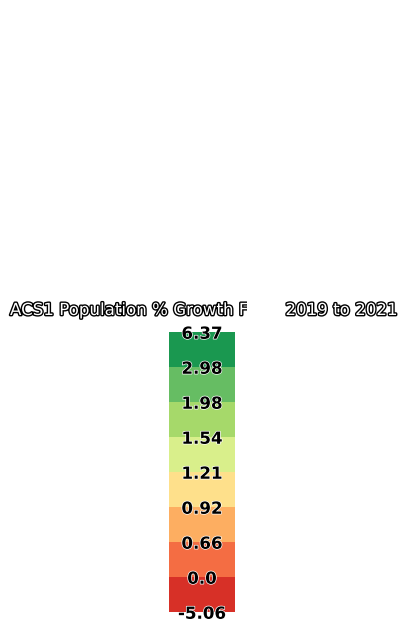

In [38]:
acs1_state_population_growth_recent_change = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = f'acs1_{second_newest_acs1_year}_to_{acs_year}_chg', feature_text = 'State', 
    data_variable_text = f'ACS1 Population % Growth From {second_newest_acs1_year} to {acs_year}', 
    map_name = f'acs1_{second_newest_acs1_year}_{acs_year}_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

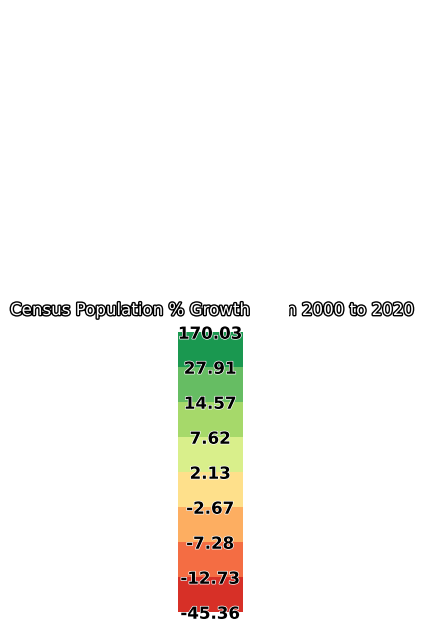

In [39]:
census_county_population_growth = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = f'census_{census_starting_year}_to_{census_year}_chg', feature_text = 'County', 
    data_variable_text = f'Census Population % Growth From {census_starting_year} to {census_year}', 
    map_name = f'census_{census_starting_year}_{census_year}_county_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

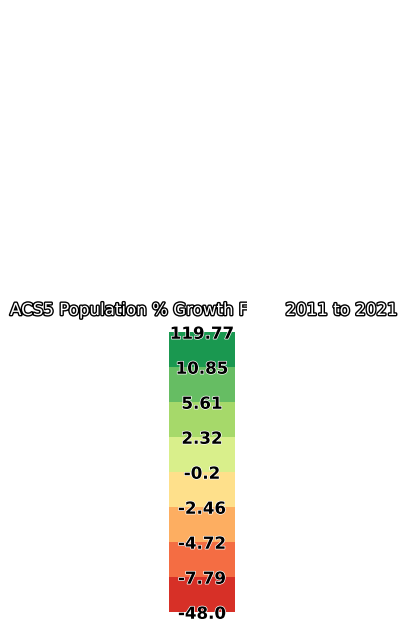

In [40]:
acs5_10_year_county_population_growth = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = f'acs5_{acs_year-10}_to_{acs_year}_chg', feature_text = 'County', 
    data_variable_text = f'ACS5 Population % Growth From {acs_year-10} to {acs_year}', 
    map_name = f'acs5_{acs_year-10}_{acs_year}_county_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

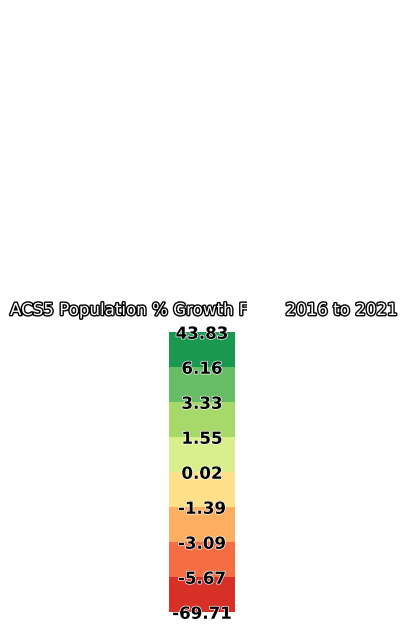

In [41]:
acs5_5_year_county_population_growth = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = f'acs5_{acs_year-5}_to_{acs_year}_chg', feature_text = 'County', 
    data_variable_text = f'ACS5 Population % Growth From {acs_year-5} to {acs_year}', 
    map_name = f'acs5_{acs_year-5}_{acs_year}_county_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

For the zip code map, zip codes with a population of 0 in the 1st year are removed, since otherwise infinite or NaN values would be returned (as dividing by 0 isn't possible). In addition, zip codes with missing coordinate polygons are also removed (via dropna(subset=['geometry']). 

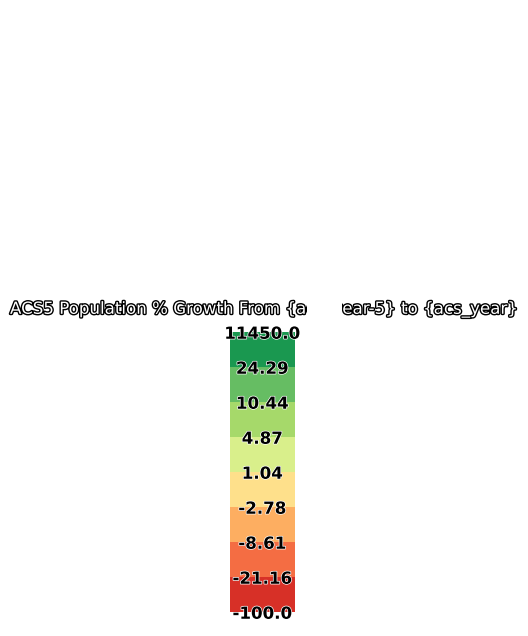

In [42]:
acs5_5_year_zip_population_growth = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query(
        f'acs5_population_{acs_year-5} > 0').dropna(
            subset=['geometry']), shape_feature_name = 'NAME',
    data_variable = f'acs5_{acs_year-5}_to_{acs_year}_chg', feature_text = 'zip', 
    data_variable_text = 'ACS5 Population % Growth From {acs_year-5} to {acs_year}', 
    map_name = f'acs5_{acs_year-5}_{acs_year}_zip_pop_growth', 
    variable_decimals = 2,
    html_save_path = html_save_path, 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

And that's it! More maps can be created with the DataFrames provided than are shown here, so feel free to experiment with the datasets and to apply the functions in census_folium_viewer to your own data tables!

In [43]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),
"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),
"second(s))") 
# Only meaningful when the program is run nonstop from start to finish

Completed run at Wed Aug  2 22:20:03 2023 (local time)
Total run time: 441.95 second(s) (7.0 minute(s) and 21.95 second(s))
